In [27]:
!pip install xgboost


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import joblib

In [29]:
file_path = "expense_data_1.csv"   
df = pd.read_csv(file_path)

In [30]:
df.head()

,Date,Account,Category,Subcategory,Note,INR,Income/Expense,Note.1,Amount,Currency,Account.1
0,3/2/2022 10:11,CUB - online payment,Food,NaN,Brownie,50.0,Expense,NaN,50.0,INR,50.0
1,3/2/2022 10:11,CUB - online payment,Other,NaN,To lended people,300.0,Expense,NaN,300.0,INR,300.0
2,3/1/2022 19:50,CUB - online payment,Food,NaN,Dinner,78.0,Expense,NaN,78.0,INR,78.0
3,3/1/2022 18:56,CUB - online payment,Transportation,NaN,Metro,30.0,Expense,NaN,30.0,INR,30.0
4,3/1/2022 18:22,CUB - online payment,Food,NaN,Snacks,67.0,Expense,NaN,67.0,INR,67.0


In [31]:
df.shape

(277, 11)

In [32]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce", dayfirst=False)
df = df[df["Income/Expense"].str.lower() == "expense"]

In [33]:
df["month_start"] = df["Date"].values.astype("datetime64[M]")
monthly = df.groupby("month_start")["Amount"].sum().reset_index()
monthly = monthly.sort_values("month_start")

In [34]:
monthly["lag_1"] = monthly["Amount"].shift(1)
monthly["lag_2"] = monthly["Amount"].shift(2)
monthly["lag_3"] = monthly["Amount"].shift(3)
monthly["rolling_3"] = monthly["Amount"].shift(1).rolling(3).mean()

monthly["month"] = monthly["month_start"].dt.month
monthly["year"] = monthly["month_start"].dt.year
monthly["month_sin"] = np.sin(2*np.pi*monthly["month"]/12)
monthly["month_cos"] = np.cos(2*np.pi*monthly["month"]/12)

monthly = monthly.dropna().reset_index(drop=True)

In [35]:
train = monthly.iloc[:-6]
test = monthly.iloc[-6:]

X_train = train.drop(columns=["Amount", "month_start"])
y_train = train["Amount"]
X_test = test.drop(columns=["Amount", "month_start"])
y_test = test["Amount"]

In [36]:
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, max_depth=4, random_state=42)
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [37]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # no squared=False here
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


MAE: 9194.83, RMSE: 12637.67


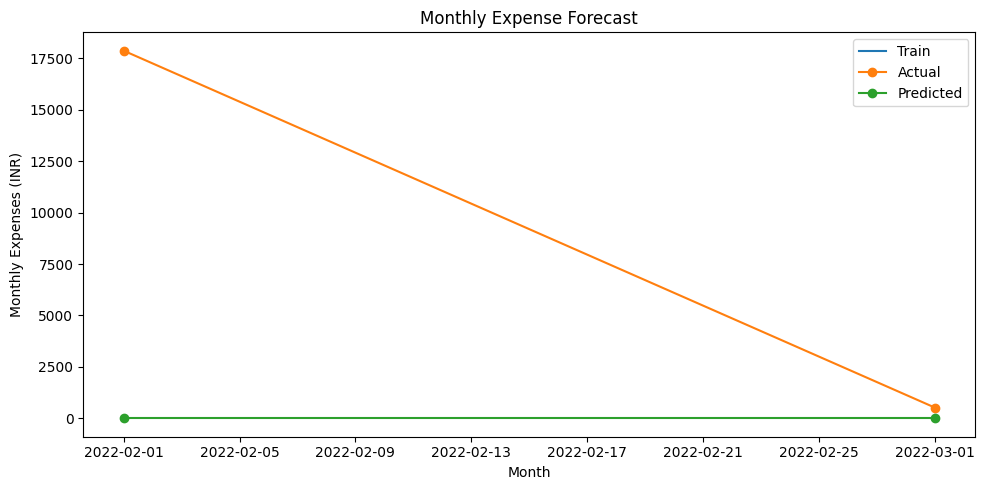

In [39]:
plt.figure(figsize=(10,5))
plt.plot(train["month_start"], y_train, label="Train")
plt.plot(test["month_start"], y_test, label="Actual", marker="o")
plt.plot(test["month_start"], y_pred, label="Predicted", marker="o")
plt.xlabel("Month")
plt.ylabel("Monthly Expenses (INR)")
plt.title("Monthly Expense Forecast")
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
last_date = monthly["month_start"].iloc[-1]
future_dates = [last_date + pd.DateOffset(months=i) for i in range(1,7)]

future = pd.DataFrame({"month_start": future_dates})
future["month"] = future["month_start"].dt.month
future["year"] = future["month_start"].dt.year
future["month_sin"] = np.sin(2*np.pi*future["month"]/12)
future["month_cos"] = np.cos(2*np.pi*future["month"]/12)

In [43]:
for i in future.index:
    # Build lag features from history safely
    for lag in [1, 2, 3]:
        if len(history) >= lag:
            future.loc[i, f"lag_{lag}"] = history["Amount"].iloc[-lag]
        else:
            future.loc[i, f"lag_{lag}"] = np.nan   # or 0 if you prefer
    
    # Rolling mean (only if enough history exists)
    if len(history) >= 3:
        future.loc[i, "rolling_3"] = history["Amount"].iloc[-3:].mean()
    else:
        future.loc[i, "rolling_3"] = np.nan   # or history["Amount"].mean()
    
    # Now we can predict
    features = future.loc[i, X_train.columns].values.reshape(1, -1)
    pred = model.predict(features)[0]
    
    future.loc[i, "Amount"] = pred
    
    # Add prediction to history
    history = pd.concat([history, future.loc[[i]]])



In [44]:
history = monthly.copy()

for i in range(len(future)):
    # Build lags
    for lag in [1,2,3]:
        if len(history) >= lag:
            future.loc[i, f"lag_{lag}"] = history["Amount"].iloc[-lag]
    if len(history) >= 3:
        future.loc[i, "rolling_3"] = history["Amount"].iloc[-3:].mean()
    
    # Predict
    features = future.loc[i, X_train.columns].values.reshape(1, -1)
    pred = model.predict(features)[0]
    future.loc[i, "Amount"] = pred
    
    # Append prediction to history
    history = pd.concat([history, future.loc[[i], ["month_start", "Amount"]]])

In [45]:
print("\n📊 Future 6-Month Forecast:")
print(future[["month_start", "Amount"]])


📊 Future 6-Month Forecast:
  month_start  Amount
0  2022-04-01     0.0
1  2022-05-01     0.0
2  2022-06-01     0.0
3  2022-07-01     0.0
4  2022-08-01     0.0
5  2022-09-01     0.0


In [46]:
joblib.dump(model, "budget_forecast_model.joblib")
print("✅ Model saved as budget_forecast_model.joblib")

✅ Model saved as budget_forecast_model.joblib


In [52]:
results = test[["month_start"]].copy()
results["Actual_Expense"] = y_test.values
results["Predicted_Expense"] = y_pred

In [53]:
print("📊 Past 6 Months (Actual vs Predicted):")
display(results)

📊 Past 6 Months (Actual vs Predicted):


,month_start,Actual_Expense,Predicted_Expense
0,2022-02-01,17864.65,0.0
1,2022-03-01,525.00,0.0


In [54]:
print("\n📜 Full Monthly Expense History:")
display(monthly[["month_start", "Amount"]])


📜 Full Monthly Expense History:


,month_start,Amount
0,2022-02-01,17864.65
1,2022-03-01,525.00


In [55]:
past = monthly[["month_start", "Amount"]].copy()
past.rename(columns={"Amount": "Actual_Expense"}, inplace=True)
past["Predicted_Expense"] = np.nan
past["Type"] = "Past Actual"

In [56]:
pred_test = test[["month_start"]].copy()
pred_test["Actual_Expense"] = y_test.values
pred_test["Predicted_Expense"] = y_pred
pred_test["Type"] = "Test (Actual vs Predicted)"

In [57]:
future_out = future[["month_start", "Amount"]].copy()
future_out.rename(columns={"Amount": "Predicted_Expense"}, inplace=True)
future_out["Actual_Expense"] = np.nan
future_out["Type"] = "Future Forecast"

In [58]:
final_results = pd.concat([past, pred_test, future_out]).sort_values("month_start").reset_index(drop=True)

print("📊 Past + Test Predictions + Future Forecast:")
display(final_results)

📊 Past + Test Predictions + Future Forecast:


C:\Users\Chitra\AppData\Local\Temp\ipykernel_6624\496759614.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_results = pd.concat([past, pred_test, future_out]).sort_values("month_start").reset_index(drop=True)


,month_start,Actual_Expense,Predicted_Expense,Type
0,2022-02-01,17864.65,NaN,Past Actual
1,2022-02-01,17864.65,0.0,Test (Actual vs Predicted)
2,2022-03-01,525.00,NaN,Past Actual
3,2022-03-01,525.00,0.0,Test (Actual vs Predicted)
4,2022-04-01,NaN,0.0,Future Forecast
5,2022-05-01,NaN,0.0,Future Forecast
6,2022-06-01,NaN,0.0,Future Forecast
7,2022-07-01,NaN,0.0,Future Forecast
8,2022-08-01,NaN,0.0,Future Forecast
9,2022-09-01,NaN,0.0,Future Forecast
